In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
import MilneEddington 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = False

This scritp calculates the emerging Stokes spectra from a resolution element with two magnetic atmospheric components (model1 and model2) with filling factor of 0.5 each. The model atmospheres are essentially identical except for the magnetic field. Both have vertical magnetic fields, but these differ in strength and orientation.

The resulting spectrum is then inverted with a one-component Milne-Eddington inversion code (pyMilne) and the resulting magnetic field strength and inclination are printed.


In [2]:
# Using only Fe I 6302 line
# This is done as in the exercises from yesterday:
regions = [[np.arange(201, dtype='float64')*0.005 + 6302.0, None]]
lines   = [ 6302]

me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

# The model is organized as:
# [|B| [G], inc [rad], azi [rad], vlos [km/s], vDop [Angstrom], eta_l, damping, S0, S1]
#

# Create two magnetic models (model1 and model2) and synthesize the spectra (syn1 and syn2)
model1 = np.float64([50., 0, 0., 0.1, 0.04, 30., 0.1, 0.2, 0.8])
model2 = np.float64([150.,np.pi , 0., 0.1, 0.04, 30., 0.1, 0.2, 0.8])

Note that the only difference between the two is in the value of the first two parameters - magnetic field and inclination! 

In [4]:
ny = 1
nx = 1
m1 = me.repeat_model(model1, ny, nx)
m2 = me.repeat_model(model2, ny, nx)
syn1 = me.synthesize(m1, mu = 1.0)
syn2 = me.synthesize(m2, mu = 1.0)

# Calculate resulting spectrum from the two-component resolution element:
ff = 0.5 # filling factor of component 1.
syn_total = ff*syn1+(1-ff)*syn2

Now, let's invert the spectrum, in a similar way as we did yesterday:

In [6]:
##Invert the combined spectrum
#-- initial guess model
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
guess = me.repeat_model(model_guess, ny, nx)

#-- set noise level - assuming standard noise level of 10^-3 for the inversion even though
# noise is not added to the spectrum. This is just to have a meaniningful values of chisquared

noise_level = 1e-3
sig = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
sig += noise_level
sig[1:3]   /= 100.
sig[3]   /= 5.
#-- do inversion       
inv_out, syn_out, chi2 = me.invert(guess, syn_total, sig, nRandom = 5, nIter=20, chi2_thres=1.0, verbose=False)

Can anyone guess the results?

In [9]:
print('Inversion results: ')
print('B = ',inv_out[0,0,0])
print('theta = ',inv_out[0,0,1]*180.0/np.pi)

Inversion results: 
B =  49.728241979014825
theta =  180.0


What? How can this be? Is the fit wrong? 

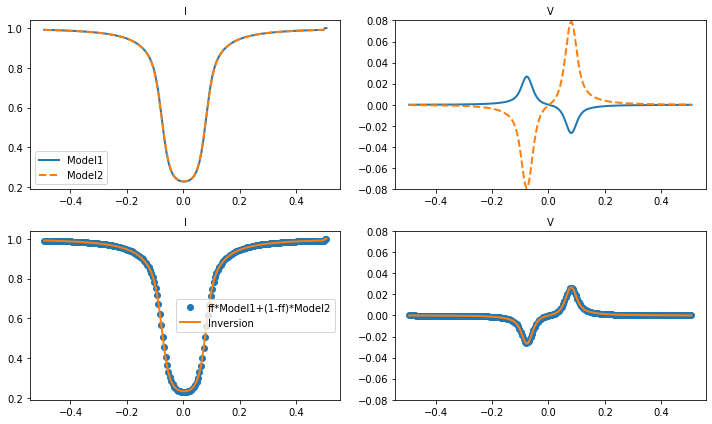

In [12]:
fig, ax = plt.subplots(2,2, figsize = (10,6))
wav = me.get_wavelength_array() - 6302.4931


ax[0,0].plot( wav,syn1[0,0,0], '-', label='Model1', linewidth=2)
ax[0,0].plot( wav,syn2[0,0,0], '--'  , linewidth=2, label='Model2')
ax[0,0].set_title('I', fontsize = 10)
ax[0,1].set_title('V', fontsize = 10)
 #       ax1[0,0].legend(loc='lower right')
ax[0,1].plot(wav, syn1[0,0,3], '-', linewidth=2)
ax[0,1].plot(wav, syn2[0,0,3], '--', linewidth=2)
handles, labels = ax[0,0].get_legend_handles_labels()
ax[0,0].legend(handles, labels, fontsize=10)
ax[0,1].set_ylim(-0.08,0.08)

# Add the magnetic and non-magnetic components with different filling factors.

ax[1,0].plot(wav, syn_total[0,0,0], 'o', linewidth=3, label='ff*Model1+(1-ff)*Model2')
ax[1,0].plot(wav, syn_out[0,0,0], '-',linewidth=2, label='Inversion')
ax[1,1].plot(wav, syn_total[0,0,3], 'o', linewidth=3)
ax[1,1].plot(wav, syn_out[0,0,3], '-',linewidth=2)
ax[1,1].set_ylim(-0.08,0.08)

handles, labels = ax[1,0].get_legend_handles_labels()
ax[1,0].legend(handles, labels, fontsize=10)
ax[1,0].set_title('I', fontsize = 10)
ax[1,1].set_title('V', fontsize = 10)
#    ax1[ii].set_ylabel(labels[ii])

#ax[0,1].set_xlabel('Wavelength - 6302.4931')
fig.tight_layout()

Can any1 discus and tell us what is going on here?